# MLB Batter OPS Prediction (2024)

## Project Overview
This project predicts the 2024 OPS (On-base Plus Slugging) for MLB players based on their past performance.  
We use historical data from 2015 to 2023 to compute features such as last season stats, career averages, and number of seasons played.  

**Goal:** Predict 2024 OPS for players and evaluate the model using regression metrics.

---

## Dataset
- Source: `cleaned_batting_stats.csv`
- Columns: 
    - `Player`, `Year`, `Age`, `OPS`, `OBP`, `SLG`, `HR`, etc.

---

## Data Preprocessing
1. Extract target variable (`OPS_2024`) from 2024 season.
2. Use data from 2015–2023 for feature generation.
3. Features:
    - Last season stats: Age, OPS, OBP, SLG, HR
    - Career mean stats: OPS, OBP, SLG, HR
    - Number of seasons played
4. Merge all features per player and align with target.

---

## Regression Model
We use **Ordinary Least Squares (OLS)** regression:

- Features: Last season stats + career averages + seasons played
- Target: OPS in 2024
- Method: `np.linalg.inv(X.T @ X) @ X.T @ y`  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv("cleaned_batting_stats.csv")

In [23]:
# Define target
target_df = df[df["Year"] == 2024][["Player", "OPS"]]
target_df = target_df.rename(columns={"OPS" : "OPS_2024"})

In [24]:
# Input Data for analysis
input_df = df[(df["Year"] >= 2015) & (df["Year"] < 2024)].copy()
input_df = input_df.sort_values(["Player", "Year"])

In [31]:
# features of last available season
last_season = input_df.groupby("Player").tail(1)

last_features = last_season[[
                "Player", "Age", "OPS", "OBP", "SLG", "HR"
                ]].rename(columns = {
                    "Age" : "Last_Age",
                    "OPS" : "Last_OPS",
                    "OBP" : "Last_OBP",
                    "SLG" : "Last_SLG",
                    "HR" : "Last_HR"})    

In [32]:
# Career mean features
mean_features = input_df.groupby("Player")[["OPS", "OBP", "SLG", "HR"]].mean().reset_index()

mean_features = mean_features.rename(columns = {
                    "OPS" : "Mean_OPS",
                    "OBP" : "Mean_OBP",
                    "SLG" : "Mean_SLG",
                    "HR" : "Mean_HR"})

In [33]:
# Number of seasons played
years_played = input_df.groupby("Player").size().reset_index(name = "Year_played")

In [35]:
# Merge all features
X_df = last_features.merge(mean_features, on = "Player", how = "left")
X_df = X_df.merge(years_played, on = "Player", how = "left")

final_df = X_df.merge(target_df, on = "Player", how = "inner")

In [36]:
# Prepare X and y
features = ["Last_Age", "Last_OPS", "Last_OBP", "Last_SLG", "Last_HR",
            "Mean_OPS", "Mean_OBP", "Mean_SLG", "Mean_HR", "Year_played"]

X = final_df[features].values.astype(float)
X = np.c_[np.ones(X.shape[0]), X]
y = final_df["OPS_2024"].values.astype(float)

In [38]:
# Compute OLS
beta = np.linalg.inv(X.T @ X) @ X.T @ y

In [39]:
# Coefficient Table
feature_names = ["Intercept"] + features

coef_df = pd.DataFrame({
            "Variable" : feature_names,
            "Coefficient" : beta})

print(coef_df)

       Variable  Coefficient
0     Intercept     0.599202
1      Last_Age    -0.005745
2      Last_OPS    19.103699
3      Last_OBP   -18.207336
4      Last_SLG   -19.396719
5       Last_HR     0.002366
6      Mean_OPS   -12.758455
7      Mean_OBP    12.266996
8      Mean_SLG    13.183164
9       Mean_HR     0.001378
10  Year_played     0.004576


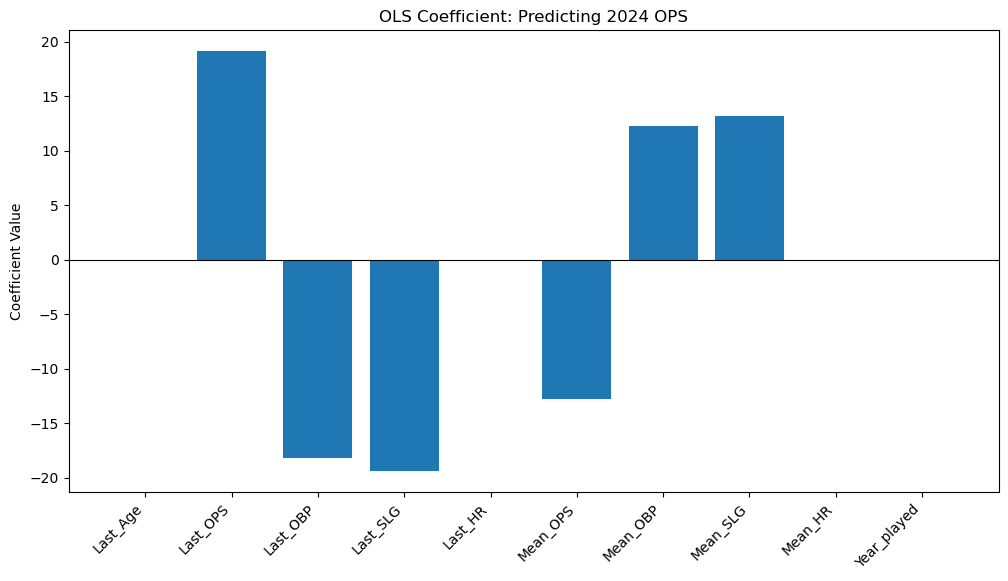

In [43]:
# Visualization
coef_plot_df = coef_df[coef_df["Variable"] != "Intercept"]

plt.figure(figsize = (12, 6))
plt.bar(coef_plot_df["Variable"], coef_plot_df["Coefficient"])
plt.axhline(0, color = "black", linewidth = 0.8)
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Coefficient Value")
plt.title("OLS Coefficient: Predicting 2024 OPS")
plt.show()

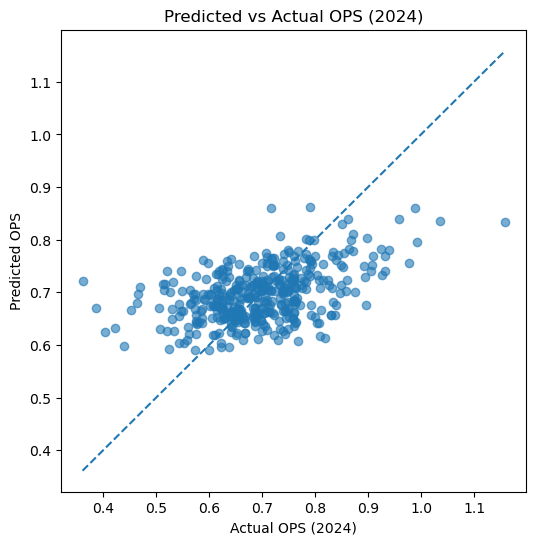

In [44]:
# simple prediction vs actual data
y_pred = X @ beta

plt.figure(figsize = (6, 6))
plt.scatter(y, y_pred, alpha = 0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle = "--")
plt.xlabel("Actual OPS (2024)")
plt.ylabel("Predicted OPS")
plt.title("Predicted vs Actual OPS (2024)")
plt.show()

In [46]:
# Model evaluation

# Mean Squared Error
mse = np.mean((y - y_pred) ** 2)
print("MSE: ", mse)

# Root Mean Squared Error
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

# # R-squared
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y- np.mean(y)) ** 2)
r2 = 1 - ss_res / ss_tot
print("R-squared: ", r2)

MSE:  0.008417403804319015
RMSE:  0.09174641030753745
R-squared:  0.23345912510869504


## Results Interpretation

### 1. Feature Importance (Coefficients)
- **Last_OPS (19.10)**: The largest positive coefficient. Players with higher OPS in the previous season are more likely to have higher OPS in the next season.  
- **Last_OBP (-18.21), Last_SLG (-19.40)**: Negative coefficients. Higher last-season OBP and SLG show a slight offset effect in this model (possibly due to multicollinearity).  
- **Mean_OPS (-12.76), Mean_OBP (12.27), Mean_SLG (13.18)**: Career average stats also contribute to the prediction. Past performance matters, but interactions with Last_OPS exist.  
- **Age (-0.0057), Year_played (0.0046), Last_HR / Mean_HR**: Smaller coefficients, indicating limited impact on OPS.

### 2. Model Performance
- **MSE / RMSE**: Measures the average difference between predicted and actual OPS.  
- **R-squared ≈ 0.23**: The model explains ~23% of the variance. In sports data, lower R² is expected due to many external factors (injuries, team strategies, etc.).

### 3. Predicted vs Actual Check
- The scatter plot shows most predictions close to actual OPS values.  
- Some players show large deviations → extreme performance changes, injuries, or team transfers not captured by the model.

### 4. Key Insights
- **Last season OPS (Last_OPS)** and **career average OPS (Mean_OPS)** are the most important predictors.  
- Simple OLS regression captures general trends but cannot fully explain player-level variations.  
